In [1]:
import pandas as pd
import numpy as np

In [2]:
#Get 1yr subset data (accidentally 364 days): 
dat = pd.read_csv("subdata_GP_365.csv", index_col = 'Unnamed: 0')
dat.loc[:, 'site'] = dat.site - 1
dat.head()

,site,year,date,MonitorData
0,0,2000,2000-01-01,NaN
1,0,2000,2000-01-02,NaN
2,0,2000,2000-01-03,NaN
3,0,2000,2000-01-04,NaN
4,0,2000,2000-01-05,NaN


In [3]:
#Change year and date to day number: 
nsites = dat.site.unique().size
days = np.tile(np.arange(364), nsites)
dat['day'] = days
dat.drop(columns = ['year', 'date'], inplace = True)
dat.head()

,site,MonitorData,day
0,0,NaN,0
1,0,NaN,1
2,0,NaN,2
3,0,NaN,3
4,0,NaN,4


In [4]:
dat.describe()

,site,MonitorData,day
count,784784.00000,154234.000000,784784.000000
mean,1077.50000,12.782746,181.500000
std,622.38392,8.781219,105.077419
min,0.00000,0.029800,0.000000
25%,538.75000,6.600000,90.750000
50%,1077.50000,10.800000,181.500000
75%,1616.25000,16.800000,272.250000
max,2155.00000,199.800000,363.000000


In [5]:
# from Qian's email, the coords in the cluster are in conic? (not GPS)
#index corresponds to site ID in dat dataframe
coords = pd.read_csv("gps_coord.csv", usecols = ['Lat', 'Lon'])
coords

,Lat,Lon
0,30.49748,-87.88026
1,33.28493,-85.80361
2,34.76262,-87.63810
3,34.28857,-85.96986
4,33.99149,-85.99265
5,31.22478,-85.39079
6,33.55306,-86.81500
7,33.33111,-87.00361
8,33.54528,-86.54917
9,33.49972,-86.92417


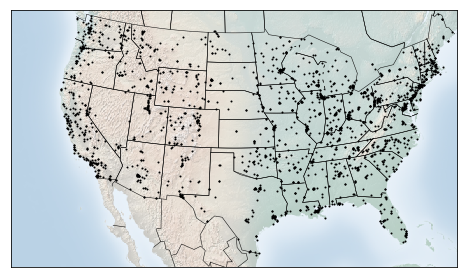

In [6]:
#Continental Map 

from mpl_toolkits.basemap import Basemap, cm
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='c',
            width=5.2E6, height=3E6, 
            lat_0=38, lon_0=-100,)
m.drawstates()
m.drawcountries()

# Map (long, lat) to (x, y) for plotting
# x, y = m(-122.3, 47.6)

for n in range(len(coords)):
    x, y = m(coords.Lon[n],  coords.Lat[n])
    
    plt.plot(x, y, 'ok', markersize=1)
    # plt.text(x, y, ' Seattle', fontsize=12);
m.shadedrelief(scale=0.5, alpha=0.5)
plt.show()

In [7]:
#Build a site to coordinate LUT
#Indices are site ID's
cartesian = ([list(m(coords.Lon[i], coords.Lat[i])) for i in range(len(coords))])
cartesian = pd.DataFrame(cartesian, columns = ['x', 'y'])
cartesian['site'] = cartesian.index

#Remove all sites outside continent (limited to just US and parts of canada)
#WOULD BE GOOD TO MAKE THIS MORE LOCALIZED (there are ~4-10 sites that are kinda sparse around canada)
continental_idx = (cartesian.x.values < 6000000) & (cartesian.x.values > -2000000)
cont_cart = cartesian[continental_idx]
cont_cart.reset_index(inplace = True, drop = True)
print(cont_cart.shape)
cont_cart.head()

(2119, 3)


,x,y,site
0,3.767606e+06,7.395587e+05,0
1,3.918865e+06,1.075913e+06,1
2,3.727703e+06,1.214838e+06,2
3,3.886732e+06,1.184200e+06,3
4,3.889622e+06,1.151151e+06,4


In [14]:
#Build and export final dataset 
dat_compact = dat.dropna()
dat_fin = pd.merge(left=dat_compact, right=cont_cart, on=['site'], how='inner')

In [15]:
dat_fin.head()

,site,MonitorData,day,x,y
0,0,5.9,15,3.767606e+06,739558.671618
1,0,11.0,18,3.767606e+06,739558.671618
2,0,8.6,21,3.767606e+06,739558.671618
3,0,6.2,24,3.767606e+06,739558.671618
4,0,7.6,27,3.767606e+06,739558.671618


In [20]:
dat_fin.to_csv('./GP_365_Preprocessed.csv')